In [1]:
!pip install jiwer

In [2]:
import tensorflow as tf
from transformers import TFAutoModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from librosa import resample, load

import os
from IPython.display import Audio
from jiwer import wer

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
# Define the checkpoint path for the pre-trained model
encoder_ckpt = 'facebook/hubert-base-ls960'
# Load the pre-trained model using the TFAutoModel class from the Transformers Library
encoder = TFAutoModel.from_pretrained(encoder_ckpt)


TFHubertModel has backpropagation operations that are NOT supported on CPU. If you wish to train/fine-tine this model, you need a GPU or a TPU
All model checkpoint layers were used when initializing TFHubertModel.

All the layers of TFHubertModel were initialized from the model checkpoint at facebook/hubert-base-ls960.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFHubertModel for predictions without further training.


# Dataset Loading & Pipeline

We have define some functions to preprocess our audio as well as text. In addition, we have prepare data pipelines for training, validation and testing with the tf.data API.

Firstly, we have to perform some cleaning on the csv file. For instance, adding in an start and end token to symbolized the start and end of the sentence. We also need to lower the case of the text as well as get the audio path.

Next, a character-based tokenizer and detokenizer are created for the text data. To create the labels, we just shift the tokens to the right as usual. For the audio data, a loading function is defined which resamples the wave form to 16.000 samples/sec, as the HuBERT model expects it, and we truncate and pad each example.

The pipeline is constructed from generator functions since our audio resampling uses the librosa library (rather than the unstable tfio API).

In [4]:
# Define the original and downsampled sample rates
SAMPLE_RATE_ORIG = 22_050
SAMPLE_RATE_DOWN = 16_000

# Specify the directory of the audio
data_path = '/kaggle/input/ljspeech/LJSpeech-1.1'

metadata = pd.read_csv(
    os.path.join(data_path, 'metadata.csv'),
    sep='|',
    header=None,
    names=['id', 'text', 'text_normalized'])

# Extract rows where normalized text is missing and attempt to recover the normalized text
text_norm_nan = metadata['text'][metadata.text_normalized.isna()]
text_recovered = text_norm_nan.str.split('|', expand=True)[1]

# Fill in the missing normalized text values with the recovered text
metadata['text_normalized'][metadata.text_normalized.isna()] = text_recovered

# Converting the text into the lower case as well as leading /trailing spaces
metadata['text_normalized'] = metadata.text_normalized.str.lower().str.strip()

# Added the <> around the normalized text to specify the start and the end of the sentences
metadata['text_normalized'] = '<' + metadata['text_normalized'] + '>'

# Concatenated the data path wave directory and audio file name with the .wav extension
metadata['audio_path'] = metadata.id.apply(lambda x: os.path.join(data_path, 'wavs', x) + '.wav')


metadata

,id,text,text_normalized,audio_path
0,LJ001-0001,"Printing, in the only sense with which we are ...","<printing, in the only sense with which we are...",/kaggle/input/ljspeech/LJSpeech-1.1/wavs/LJ001...
1,LJ001-0002,in being comparatively modern.,<in being comparatively modern.>,/kaggle/input/ljspeech/LJSpeech-1.1/wavs/LJ001...
2,LJ001-0003,For although the Chinese took impressions from...,<for although the chinese took impressions fro...,/kaggle/input/ljspeech/LJSpeech-1.1/wavs/LJ001...
3,LJ001-0004,"produced the block books, which were the immed...","<produced the block books, which were the imme...",/kaggle/input/ljspeech/LJSpeech-1.1/wavs/LJ001...
4,LJ001-0005,the invention of movable metal letters in the ...,<the invention of movable metal letters in the...,/kaggle/input/ljspeech/LJSpeech-1.1/wavs/LJ001...
...,...,...,...,...
13095,LJ050-0274,made certain recommendations which it believes...,<made certain recommendations which it believe...,/kaggle/input/ljspeech/LJSpeech-1.1/wavs/LJ050...
13096,LJ050-0275,materially improve upon the procedures in effe...,<materially improve upon the procedures in eff...,/kaggle/input/ljspeech/LJSpeech-1.1/wavs/LJ050...
13097,LJ050-0276,"As has been pointed out, the Commission has no...","<as has been pointed out, the commission has n...",/kaggle/input/ljspeech/LJSpeech-1.1/wavs/LJ050...
13098,LJ050-0277,with the active cooperation of the responsible...,<with the active cooperation of the responsibl...,/kaggle/input/ljspeech/LJSpeech-1.1/wavs/LJ050...


In [5]:
# Splitting the data into train and test set
train_df, test_df = train_test_split(metadata, test_size=1_000, shuffle=True, random_state=42)

# Split the train set into train and validation set
train_df, val_df = train_test_split(train_df, test_size=500, shuffle=True, random_state=42)

train_df.info(), val_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11600 entries, 5539 to 2925
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               11600 non-null  object
 1   text             11600 non-null  object
 2   text_normalized  11600 non-null  object
 3   audio_path       11600 non-null  object
dtypes: object(4)
memory usage: 453.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 6371 to 11340
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               500 non-null    object
 1   text             500 non-null    object
 2   text_normalized  500 non-null    object
 3   audio_path       500 non-null    object
dtypes: object(4)
memory usage: 19.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 4347 to 4091
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
--- 

(None, None, None)

In [6]:
# Create a TensorFlow Dataset Object for Training
train_audio = tf.data.Dataset.from_tensor_slices(train_df['audio_path'])
train_text = tf.data.Dataset.from_tensor_slices(train_df['text_normalized'])
train_ds = tf.data.Dataset.zip((train_audio, train_text))

# Creating a Tensorflow Dataset Object for Validation
val_audio = tf.data.Dataset.from_tensor_slices(val_df['audio_path'])
val_text = tf.data.Dataset.from_tensor_slices(val_df['text_normalized'])
val_ds = tf.data.Dataset.zip((val_audio, val_text))

# Creating a Tensorflow Dataset Object for Testing
test_audio = tf.data.Dataset.from_tensor_slices(test_df['audio_path'])
test_text = tf.data.Dataset.from_tensor_slices(test_df['text_normalized'])
test_ds = tf.data.Dataset.zip((test_audio, test_text))

In [7]:
# Preprocessing the decoder

# Define the maximum length of the text sequences after vectorization
TEXT_MAXLEN = 200

# Tokenize text into character-level sequences of integers
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=70,
    standardize=None,
    split='character',
    output_mode='int',
    output_sequence_length=TEXT_MAXLEN+1)

# Apply thr text vectorization to the training data to build up its vocabulary
text_vectorizer.adapt(train_df.text_normalized)

vocab = text_vectorizer.get_vocabulary()
vocab_size = text_vectorizer.vocabulary_size()

#  Map integer indicies back to token in the vocabulary
detokenizer = tf.lookup.StaticHashTable(
    initializer = tf.lookup.KeyValueTensorInitializer(
        keys=range(len(vocab)),
        values=vocab,
        key_dtype=tf.int64),
    default_value='[UNK]')

vocab_size, vocab, detokenizer

(53,
 ['',
  '[UNK]',
  ' ',
  'e',
  't',
  'a',
  'o',
  'n',
  'i',
  's',
  'r',
  'h',
  'd',
  'l',
  'c',
  'f',
  'u',
  'm',
  'w',
  'p',
  'g',
  'y',
  'b',
  ',',
  '>',
  '<',
  'v',
  '.',
  'k',
  'x',
  '-',
  'q',
  'j',
  "'",
  '"',
  ';',
  'z',
  ':',
  ')',
  '(',
  '?',
  '!',
  'ü',
  ']',
  '[',
  '”',
  '“',
  'é',
  '’',
  'ê',
  'è',
  'â',
  'à'],
 <tensorflow.python.ops.lookup_ops.StaticHashTable at 0x7eae7c24ad70>)

In [8]:
# Preprocessing the encoder

AUDIO_MAXLEN = 10*SAMPLE_RATE_DOWN

# Function to load and preprocess the audio files
def load_wav(file_path):
    # Read the audio file as binary data
    audio_binary = tf.io.read_file(file_path)
    # Decode the binary audio data, extracting wavform
    waveform, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
    waveform = tf.squeeze(waveform, axis=-1)
    
    # Resample the waveforms to match the downsampled sample rate
    waveform = resample(
        y=waveform.numpy(),
        orig_sr=SAMPLE_RATE_ORIG,
        target_sr=SAMPLE_RATE_DOWN)
    waveform = tf.cast(waveform, tf.float32)[:AUDIO_MAXLEN]

    # Pad the waveforms if its length is less than AUDIO_MAXLEN
    target_len = AUDIO_MAXLEN
    x_len = tf.shape(waveform)
    num_pads = target_len - x_len
    zero_pads = tf.zeros(shape=(num_pads))
    waveform = tf.concat([waveform, zero_pads], axis=0)
    return waveform

In [9]:
# building a pipeline with data generators

# Define a function to preprocess audio
def generate_audiopaths(data_partition: pd.Series):
    for p in data_partition:
        wav = load_wav(p)
        # Compute the mean and standard deviation of the waveforms
        mean = tf.math.reduce_mean(wav, axis=0, keepdims=True)
        std = tf.math.reduce_std(wav, axis=0, keepdims=True)
        # Standardise the waveform
        wav = (wav - mean) / std
        yield wav

# Define a function to preprocess text
def generate_texts(data_partition: pd.Series):
    for t in data_partition:
        yield text_vectorizer(t)


path_train = tf.data.Dataset.from_generator(
    generate_audiopaths,
    args=[train_df.audio_path],
    output_signature=(tf.TensorSpec(shape=(AUDIO_MAXLEN), dtype=tf.float32)))
path_val = tf.data.Dataset.from_generator(
    generate_audiopaths,
    args=[val_df.audio_path],
    output_signature=(tf.TensorSpec(shape=(AUDIO_MAXLEN), dtype=tf.float32)))
path_test = tf.data.Dataset.from_generator(
    generate_audiopaths,
    args=[test_df.audio_path],
    output_signature=(tf.TensorSpec(shape=(AUDIO_MAXLEN), dtype=tf.float32)))

text_train = tf.data.Dataset.from_generator(
    generate_texts,
    args=[train_df.text_normalized],
    output_signature=(tf.TensorSpec(shape=(TEXT_MAXLEN+1), dtype=tf.int64)))
text_val = tf.data.Dataset.from_generator(
    generate_texts,
    args=[val_df.text_normalized],
    output_signature=(tf.TensorSpec(shape=(TEXT_MAXLEN+1), dtype=tf.int64)))
text_test = tf.data.Dataset.from_generator(
    generate_texts,
    args=[test_df.text_normalized],
    output_signature=(tf.TensorSpec(shape=(TEXT_MAXLEN+1), dtype=tf.int64)))


train_ds = tf.data.Dataset.zip((path_train, text_train))
val_ds = tf.data.Dataset.zip((path_val, text_val))
test_ds = tf.data.Dataset.zip((path_test, text_test))

In [10]:
def prepare_data_pipeline(audio, text):
    text_in = text[:-1]
    text_target = text[1:]
    # Convert the target text sequence into one-hot encoded format
    text_target = tf.one_hot(text_target, vocab_size)

    audio = tf.ensure_shape(audio, (AUDIO_MAXLEN))
    text_in = tf.ensure_shape(text_in, (TEXT_MAXLEN))
    text_target = tf.ensure_shape(text_target, (TEXT_MAXLEN, vocab_size))

    return (audio, text_in), text_target

In [11]:
BATCH_SIZE = 32

# Applying the prepare_data_pipeline function to each element, batch the data into smaller batches and prefetching batches to speed up the training
train_ds = (train_ds
            .map(prepare_data_pipeline, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (val_ds
            .map(prepare_data_pipeline, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

test_ds = (test_ds
            .map(prepare_data_pipeline, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

train_ds, val_ds, test_ds

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 160000), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 200, 53), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 160000), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 200, 53), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 160000), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 200, 53), dtype=tf.float32, name=None))>)

In [12]:
# draw an illustrative sample batch from the pipeline

for ex_processed_batch in train_ds.take(1):
    print(type(ex_processed_batch), type(ex_processed_batch[0]), type(ex_processed_batch[1]))
    (ex_audio, ex_text), ex_target = ex_processed_batch
    print(ex_audio.shape)
    print(ex_text.shape)
    print(ex_target.shape)

<class 'tuple'> <class 'tuple'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 160000)
(32, 200)
(32, 200, 53)


# Architectural Building Blocks

### Encoder Side

For the encoder we do not have to do much. We can simply use the HuBERT model and define it as a custom layer. Since we do not finetune the model but rather use it only as a feature extractor, we freeze this layer so its weights do not get updated during backpropagation.

In [13]:
Audio(ex_audio[0], rate=SAMPLE_RATE_DOWN)

<Axes: >

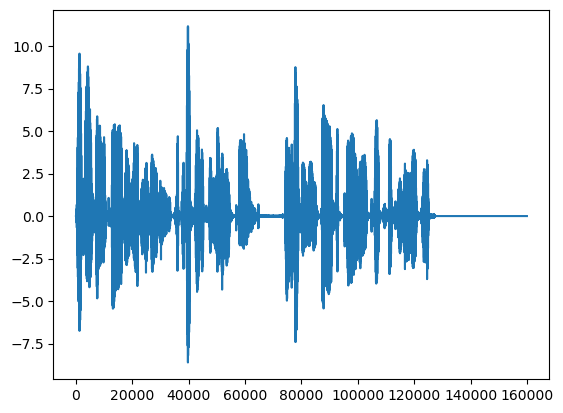

In [14]:
sns.lineplot(ex_audio[0])

In [15]:
ex_encoder_output = encoder(tf.expand_dims(ex_audio[0], axis=0))
ex_encoder_output

TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(1, 499, 768), dtype=float32, numpy=
array([[[ 0.10362744,  0.3122011 ,  0.24610582, ...,  0.03205444,
          0.04107486, -0.36726624],
        [ 0.09637075, -0.08753417,  0.39171514, ..., -0.14177558,
         -0.19720273,  0.2975998 ],
        [ 0.03050634, -0.10710379,  0.43060708, ..., -0.02579856,
         -0.35958764,  0.16022193],
        ...,
        [-0.01615791,  0.15192623, -0.0440532 , ..., -0.13910335,
         -0.2945968 , -0.09767205],
        [ 0.03546117,  0.19252613,  0.01927604, ..., -0.10173468,
         -0.1245732 , -0.12694818],
        [ 0.04011991,  0.20524862,  0.02816102, ..., -0.10062812,
         -0.08583458, -0.14834331]]], dtype=float32)>, hidden_states=None, attentions=None)

In [16]:
class AudioExtraction(tf.keras.layers.Layer):
    def __init__(self, extractor, trainable=False):
        super().__init__()
        # Initialize the layer with an extractor model and a trainable flag
        self.extractor = extractor
        self.trainable = trainable
        
    @tf.function
    def call(self, inputs):
        # Apply the extracted model to the input data to extract features
        features = self.extractor(inputs)
        return features.values().mapping['last_hidden_state']
    
    # Save and restore layer configurations
    def get_config(self):
        config = super().get_config()
        config.update({
            'extractor': self.extractor, 
            'trainable': self.trainable
        })

In [17]:
audio_extraction = AudioExtraction(extractor=encoder)
audio_extraction.trainable

False

In [18]:
ex_extraction_out = audio_extraction(ex_audio[0:2])
ex_extraction_out

<tf.Tensor: shape=(2, 499, 768), dtype=float32, numpy=
array([[[ 0.10362756,  0.31220058,  0.24610555, ...,  0.03205491,
          0.04107514, -0.36726642],
        [ 0.09637088, -0.08753413,  0.3917153 , ..., -0.14177558,
         -0.19720222,  0.29759958],
        [ 0.0305061 , -0.10710371,  0.43060634, ..., -0.02579905,
         -0.35958776,  0.16022196],
        ...,
        [-0.01615749,  0.15192644, -0.04405335, ..., -0.13910328,
         -0.2945965 , -0.09767194],
        [ 0.03546172,  0.19252598,  0.01927617, ..., -0.10173476,
         -0.12457229, -0.12694748],
        [ 0.04012063,  0.205248  ,  0.02816086, ..., -0.10062842,
         -0.08583371, -0.14834335]],

       [[-0.00300652,  0.18605581,  0.17891654, ...,  0.07804507,
         -0.01703409, -0.0607977 ],
        [ 0.25419408,  0.11826919,  0.03578835, ..., -0.1062666 ,
          0.13685435, -0.6277999 ],
        [-0.04706888,  0.39133963, -0.09853664, ..., -0.16250819,
         -0.09955153, -0.33229297],
        ...,

### Decoder

For the decoder, We have defined an embedding layer and an attention block layer. We use learnable positional embeddings (not fixed sinusoidal functions)

In [19]:
# Define a custome keras layer which combine character embeddings with positional embeddings
class TextEmbedding(tf.keras.layers.Layer):
    def __init__(self, d_model, maxlen):
        super().__init__()
        self.d_model = d_model
        self.maxlen = maxlen
        # Character embedding layer
        self.char_embed_layer = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=self.d_model, mask_zero=True)
        # Positional embedding layer
        self.pos_embed_layer = tf.keras.layers.Embedding(
            input_dim=self.maxlen, output_dim=self.d_model)

    @tf.function
    def call(self, inputs):
        x = inputs
        x = self.char_embed_layer(x)
        pos_tensor = tf.range(0, tf.shape(x)[1])
        pos_embed = self.pos_embed_layer(pos_tensor)
        # Adding positional embeddings to character embeddings
        return x + pos_embed

    # Ensure that layer paramaters are correctly saved 
    def get_config(self):
        config = super().get_config()
        config.update({
            'd_model': self.d_model,
            'maxlen': self.maxlen
        })

In [20]:
class DecoderAttentionBlock(tf.keras.layers.Layer):
    def __init__(self, num_heads=4, d_model=256, dropout=0.15, ffn_dim=1024):
        super().__init__()
        # Initialize parameters
        self.d_model = d_model
        self.num_heads = num_heads
        self.dropout = dropout
        self.ffn_dim = ffn_dim
        
        # Define causal self-attention layer
        self.causal_self_attention = tf.keras.layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.d_model,
            dropout=self.dropout)
        
        # Define layer normalization
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        # Define the cross-attention layer
        self.cross_attention = tf.keras.layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.d_model,
            dropout=self.dropout)

        # Define feed-forward network
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(self.ffn_dim, activation='relu'),
             tf.keras.layers.Dropout(self.dropout),
             tf.keras.layers.Dense(self.d_model)])

    @tf.function
    def call(self, inputs, encoder_context):
        # Perform self-attention on inputs
        x = inputs
        self_att_out = self.causal_self_attention(x, x, use_causal_mask=True)
        # Apply layer-normalization after self-attention
        self_embeds = self.layernorm1(x + self_att_out)
        # Apply cross-attention with encoder context
        cross_att = self.cross_attention(self_embeds, encoder_context)
        # Apply layer notmalization after cross-attention
        context_embeds = self.layernorm2(self_embeds + cross_att)
        # Pass through feed-forward network
        projections = self.ffn(context_embeds)
        # Apply layer-normalization after feed-forward networkk
        block_output = self.layernorm3(context_embeds + projections)
        return block_output

    def get_config(self):
        config = super().get_config()
        config.update({
            'num_heads': self.num_heads,
            'd_model': self.d_model,
            'dropout': self.dropout,
            'ffn_dim': self.ffn_dim
        })
        return config

# The Full Model

To assemble the whole model, we can use the Functional API since the data flow is rather straight-forward: We extract features from the audio and allow the text embeddings to interact with these features at each layer. Additionally, we add a linear classifier on top to predict the next token's logits.  I also defined a small function which decodes those logit outputs back to text - this will come in handy during the training phase.

In [21]:
from tensorflow.keras.layers import Input, Dense

In [22]:
# Define the input layers for the encoder and decoder
decoder_in = Input(shape=(None,), name='decoder_text_input') #200
encoder_in = Input(shape=(160000,), name='encoder_audio_input') #160000

# Extract audio features using the specified extractor
audio_features = AudioExtraction(extractor=encoder)(encoder_in)

# Embed the text input for the decoder
text_embeds = TextEmbedding(d_model=256, maxlen=200)(decoder_in)

# Pass the text embeddings through a decoder attention block with multi-head attention and layer normalization
text_embeds = DecoderAttentionBlock(
    num_heads=6, d_model=256, dropout=0.15, ffn_dim=1024)(text_embeds, audio_features)

# Pass the contextualized embeddings through another decoder attention block for further refinement
text_embeds = DecoderAttentionBlock(
    num_heads=6, d_model=256, dropout=0.15, ffn_dim=1024)(text_embeds, audio_features)

#Generate logits by passing the processed text embeddings through a dense layer
logits = Dense(vocab_size)(text_embeds)

# Define the Transformer model with encoder and decoder as the input and the logits as the output
transformer = tf.keras.Model(inputs=[encoder_in, decoder_in], outputs=[logits])
transformer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_text_input (InputLayer  [(None, None)]      0           []                               
 )                                                                                                
                                                                                                  
 encoder_audio_input (InputLaye  [(None, 160000)]    0           []                               
 r)                                                                                               
                                                                                                  
 text_embedding (TextEmbedding)  (None, None, 256)   64768       ['decoder_text_input[0][0]']     
                                                                                              

In [23]:
# test a forward pass
ex_model_output = transformer((ex_audio[:2], ex_text[:2]))
ex_model_output

<tf.Tensor: shape=(2, 200, 53), dtype=float32, numpy=
array([[[-2.0992072 ,  0.5605995 ,  2.4256349 , ..., -0.5438299 ,
          0.86825407,  0.6336806 ],
        [-2.3044934 ,  0.73514354, -0.10110366, ..., -1.2698956 ,
          1.0740398 ,  0.43679047],
        [-0.23294955, -0.00543487, -0.5869105 , ..., -1.1266959 ,
          0.13430195,  0.65902007],
        ...,
        [ 0.51466656,  1.2846805 , -0.31596994, ...,  1.6306605 ,
          0.19722724,  0.5675181 ],
        [-0.73727196, -0.4244917 ,  0.2875086 , ..., -0.39745736,
          0.46730858, -0.12303674],
        [ 0.76437235,  0.00611445,  0.30918407, ...,  1.278857  ,
         -1.4869882 ,  1.5819104 ]],

       [[-2.1027792 ,  0.56424564,  2.4273188 , ..., -0.5424759 ,
          0.8739327 ,  0.62840956],
        [-2.0075169 ,  1.68785   , -0.6740806 , ..., -3.4443927 ,
          0.10483932,  0.95490235],
        [-2.3540325 , -0.22338057, -0.36717007, ..., -0.1529274 ,
         -0.65835154, -0.02919209],
        ...,


In [24]:
# decode model outputs

def decode_model_outputs(logits):
    # Obtain token predictions by selecting the index with the highest probability along the last axis
    token_preds = tf.argmax(logits, axis=-1)
    # Look up characters corresponding to token predictions using a detokenizer
    char_preds = detokenizer.lookup(token_preds)
    # Transpose the character predictions to match the original shape
    char_preds = tf.transpose(char_preds, perm=[1, 0])
    # Concatenate characters to form strings
    string_preds = tf.strings.join(char_preds)
    # Split strings to remove the padding symbol and convert to tensor
    string_preds = tf.strings.split(string_preds, '>', maxsplit=1).to_tensor()
    # Return only the decoded strings without padding
    return string_preds[:, 0]
    
# Decode the model outputs to obtain human-readable strings
ex_outputs_decoded = decode_model_outputs(ex_model_output)
ex_outputs_decoded

<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b"\xe2\x80\x9dz\xe2\x80\x9dm[UNK]tf)b\xc3\xbcmvm\xc3\xa0h)f\xc3\xa9h\xc3\xbc\xc3\xa0dv.i x d\xc3\xa9dd :\xe2\x80\x9ddpnpv'\xe2\x80\x9c\xe2\x80\x9c?d\xc3\xa9.' \xc3\xa9p-dmpcdddh<m-tcn)t\xc3\xa9'm-xdo]chh\xc3\xa9;\xe2\x80\x9c\xc3\xbcv\xc3\xa2\xe2\x80\x9dip).:d\xe2\x80\x9cp?",
       b"\xe2\x80\x9d.k\xc3\xa2z fmfvhm.\xc3\xa0h)\xc3\xaa'p.\xc3\xa0)v.d   -\xc3\xa9dc.\xc3\xa8m..pn \xc3\xa0\xc3\xa9ddd\xc3\xa9.' \xc3\xa9\xe2\x80\x9cm\xc3\xa8 d\xc3\xa2\xc3\xa0cmv.dq\xc3\xbcum) s)d-h \xc3\xa9)dfh:\xc3\xaa\xc3\xa0fp-.m\xc3\xaar \xc3\xa8fam\xc3\xbcv. -\xe2\x80\x9cmppxm\xc3\xa9zmm\xc3\xa9\xe2\x80\x9d\xc3\xaa.hdmph-''s.ddm\xc3\xbc:ap'vvtvvv\xe2\x80\x9dffv\xe2\x80\x9dv]dfvtvvfvffv]f:fv\xe2\x80\x9dx\xe2\x80\x9dxtvvxvt'\xe2\x80\x9d?\xe2\x80\x9dtvvd\xe2\x80\x9dh]]vffdv\xe2\x80\x9d\xe2\x80\x9dfvv'fxvvfdf"],
      dtype=object)>

In [25]:
print(ex_outputs_decoded[0].numpy())
print()

ex_targets_decoded = decode_model_outputs(ex_target)
print(ex_targets_decoded[0].numpy())

b"\xe2\x80\x9dz\xe2\x80\x9dm[UNK]tf)b\xc3\xbcmvm\xc3\xa0h)f\xc3\xa9h\xc3\xbc\xc3\xa0dv.i x d\xc3\xa9dd :\xe2\x80\x9ddpnpv'\xe2\x80\x9c\xe2\x80\x9c?d\xc3\xa9.' \xc3\xa9p-dmpcdddh<m-tcn)t\xc3\xa9'm-xdo]chh\xc3\xa9;\xe2\x80\x9c\xc3\xbcv\xc3\xa2\xe2\x80\x9dip).:d\xe2\x80\x9cp?"

b'there had been a pause in legislation, except of a permissive kind. the second and third victoria, cap. fifty-six'


In [26]:
detokenizer.lookup(tf.argmax(ex_target[0], axis=-1))

<tf.Tensor: shape=(200,), dtype=string, numpy=
array([b't', b'h', b'e', b'r', b'e', b' ', b'h', b'a', b'd', b' ', b'b',
       b'e', b'e', b'n', b' ', b'a', b' ', b'p', b'a', b'u', b's', b'e',
       b' ', b'i', b'n', b' ', b'l', b'e', b'g', b'i', b's', b'l', b'a',
       b't', b'i', b'o', b'n', b',', b' ', b'e', b'x', b'c', b'e', b'p',
       b't', b' ', b'o', b'f', b' ', b'a', b' ', b'p', b'e', b'r', b'm',
       b'i', b's', b's', b'i', b'v', b'e', b' ', b'k', b'i', b'n', b'd',
       b'.', b' ', b't', b'h', b'e', b' ', b's', b'e', b'c', b'o', b'n',
       b'd', b' ', b'a', b'n', b'd', b' ', b't', b'h', b'i', b'r', b'd',
       b' ', b'v', b'i', b'c', b't', b'o', b'r', b'i', b'a', b',', b' ',
       b'c', b'a', b'p', b'.', b' ', b'f', b'i', b'f', b't', b'y', b'-',
       b's', b'i', b'x', b'>', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b

# Compilation: Loss Function, Metric, Callbacks, Learning Rate Schedule

To compile our model, we first would need to define our loss function and in our case we are using the categorical cross-entropy. In order to account for the padding token, we have to mask them. Similarly, we have to do the same for the accuracy metrics.

As for the optimizer, we will be using Adam. We have also define a learning rate schedule which can be adjusted according to the number of steps it take during the training,

Two callback was also defined, one of which is to saved the model checkpoint at every 5 epochs while the other one is used to monitor the predictions during the training and calculate the WER.

In [27]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self, name='masked_loss'):
        super(MaskedLoss, self).__init__(name=name)
        # Initialize the loss object with categorical cross-entropy settings
        self.loss_object = tf.keras.losses.CategoricalCrossentropy(
            from_logits=True, reduction='none', label_smoothing=0.1)

    def call(self, label, pred):
        mask = tf.argmax(label, axis=-1) != 0

        loss = self.loss_object(label, pred)
        mask = tf.cast(mask, dtype=loss.dtype)

        loss *= mask
        # Calculate the masked loss reduction by dividing the sum of losses by the sum of the mask
        loss_reduction = tf.reduce_sum(loss) / tf.reduce_sum(mask)
        return loss_reduction

In [28]:
# Metrics used to evaluate the accuracy of the prediction
class MaskedAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='masked_accuracy', **kwargs):
        super(MaskedAccuracy, self).__init__(name=name, **kwargs)
        # Initialize metrics to track the number of correct predictions and the total number of masked elements
        self.match_metric = self.add_weight(name='match_metric', initializer='zeros')
        self.mask_metric = self.add_weight(name='mask_metric', initializer='zeros')

    def update_state(self, label, pred, sample_weight=None):
        pred = tf.argmax(pred, axis=-1)
        label = tf.argmax(label, axis=-1)
        label = tf.cast(label, pred.dtype)
        _match = label == pred

        mask = label != 0

        _match = _match & mask

        _match = tf.cast(_match, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)

        self.match_metric.assign_add(tf.reduce_sum(_match))
        self.mask_metric.assign_add(tf.reduce_sum(mask))

    def result(self):
        return self.match_metric / self.mask_metric

    def reset_state(self):
        self.match_metric.assign(0.0)
        self.mask_metric.assign(0.0)

In [29]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        # Define the model dimension and number of warmup steps
        self.d_model_int = d_model
        self.d_model = tf.cast(self.d_model_int, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        # Calculate learning rate scheduler
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        config = {"d_model": (self.d_model_int), "warmup_steps": self.warmup_steps}
        return config

In [30]:
# Saved the model as a checkpoint at the end of every specified number of epochs
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, freq, file_path):
        super().__init__()
        self.freq = freq
        self.file_path = file_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.freq == 0:
            print('\n-------SAVING MODEL CHECKPOINT-------\n')
            tf.saved_model.save(transformer, f'TrainingCheckpoint_{epoch+1}')
            print(f'\n-------CHECKPOINT FOR EPOCH {epoch+1} SUCCESSFUL-------\n')


In [31]:
# Function to calculate the wer
def calculate_wer(predictions, targets):
    # Calculate WER
    wer_value = wer(targets, predictions)
    # Normalize the wer value to be between 0 and 1
    wer_value = min(wer_value, 1.0)
    return wer_value

In [32]:
# Monitor model predictions during training and save the WER into an output file
class PredictionMonitor(tf.keras.callbacks.Callback):
    def __init__(self, data_sample, freq, output_file):
        super().__init__()
        self.data_sample = data_sample 
        self.freq = freq
        self.output_file = output_file
        self.wer_values = []

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.freq == 0:
            print('\n------- MONITORING -------\n')

            (audio_in, text_in), text_target = self.data_sample
            logits = transformer((audio_in, text_in))
            text_preds = decode_model_outputs(logits)
            
            for i in range(len(text_preds)):
                pred_str = text_preds[i].numpy().decode('utf-8')
                target_str = decode_model_outputs(tf.expand_dims(text_target[i], 0))[0].numpy().decode('utf-8')

                wer_value = calculate_wer([pred_str], [target_str])
                print(f'PRED_{i}: {pred_str}')
                print(f'TARGET_{i}: {target_str}')
                print(f'Word Error Rate for PRED_{i}: {wer_value:.4f}\n')
                self.wer_values.append(wer_value)

                # Save WER value to the output file
                with open(self.output_file, 'a') as f:
                    f.write(f'Epoch {epoch+1}, PRED_{i}: WER = {wer_value:.4f}\n')

In [33]:
# Set up training configuration using Adam as the optimizer
transformer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=CustomSchedule(d_model=256)),
    loss=MaskedLoss(),
    metrics=[MaskedAccuracy()])

# Model Training

We trained our model with both 30 and 50 epochs and perform evaluation on our test dataset.


In [34]:
# instantiate all call backs

for (monitor_audio, monitor_text), monitor_target in val_ds.take(1):
    pass

monitor = PredictionMonitor(
            data_sample=((monitor_audio[:4], monitor_text[:4]), monitor_target[:4]),
            freq=3,
            output_file='wer_score.txt')


# Saved model checkpoints every 5 epo0chs
checkpoints = CustomModelCheckpoint(freq=5, file_path='TrainingCheckpoint')

# Initialize early stopping to stop training if val accuracy does not improve
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_masked_acc',
    mode='max',
    min_delta=0.001,
    restore_best_weights=True,
    patience=3)

In [35]:
transformer.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds,
    callbacks=[monitor, checkpoints, early_stop])

Epoch 1/5
363/363 [==============================] - 763s 2s/step - loss: 3.1210 - masked_accuracy: 0.2240 - val_loss: 2.7162 - val_masked_accuracy: 0.2883
Epoch 2/5
363/363 [==============================] - 590s 2s/step - loss: 2.6091 - masked_accuracy: 0.3211 - val_loss: 2.3817 - val_masked_accuracy: 0.4009
Epoch 3/5
363/363 [==============================] - ETA: 0s - loss: 2.1484 - masked_accuracy: 0.4796
------- MONITORING -------

PRED_0: ween cas sscf chis ceneecccore i                       
TARGET_0: when cases of this kind occur,
Word Error Rate for PRED_0: 1.0000

PRED_1: as rrrrsort rf rhat roneers tiong aonrngtrswald reop  cha coven  anpet   on ohs org  n oonve stng tdrr ue,  moe mad frrot made 
TARGET_1: as a result of that conversation, marina oswald wrote the soviet embassy in washington concerning a request she had first made
Word Error Rate for PRED_1: 1.0000

PRED_2: ononovember nmghte nogetenn sixty-threet
TARGET_2: on november eight, nineteen sixty-three,
Word Err

In [36]:
# Saved the weights of the trained model
transformer.save_weights('/kaggle/working/Transformer_with_HuBERT_5.weights.h5')

/opt/conda/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


# Model Results and Prediction

Based on the results, we have observed that with a smaller epochs of 30 it seems to be able to transcribe better for shoter sentences. While with a higher epochs of 50, it is able to transcribe better for longer sentences.

In [41]:
# Save the training history of the model into a csv file

training_history = pd.DataFrame(transformer.history.history)
training_history.to_csv('training_history.csv')
training_history

""


<Axes: ylabel='masked_accuracy'>

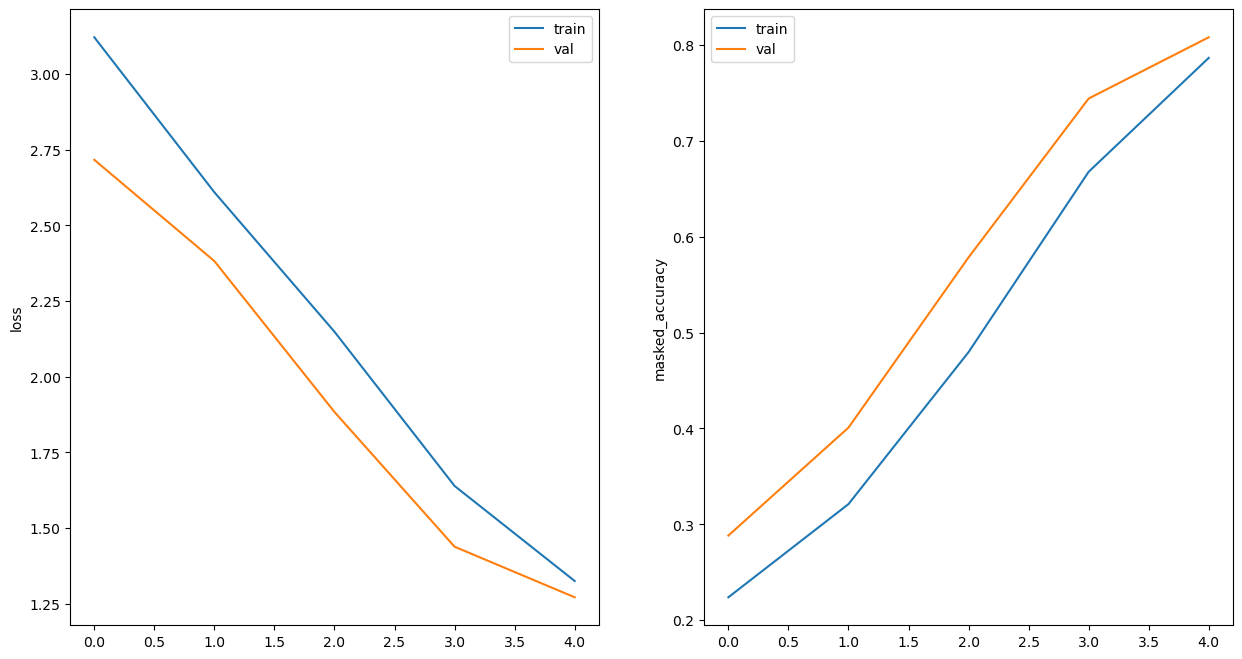

In [38]:
# Plot out the loss and the masked accuracy
plt.rcParams['figure.figsize'] = (15, 8)
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.lineplot(training_history.loss, label='train', ax=ax1)
sns.lineplot(training_history.val_loss, label='val', ax=ax1)

sns.lineplot(training_history.masked_accuracy, label='train', ax=ax2)
sns.lineplot(training_history.val_masked_accuracy, label='val', ax=ax2)

In [39]:
# evaluate on test set
transformer.evaluate(test_ds)

32/32 [==============================] - 60s 2s/step - loss: 1.2761 - masked_accuracy: 0.8064


[1.276099443435669, 0.8063750267028809]

In [40]:
# Predict on model with 30 epochs

# Load the weights into the model
transformer.load_weights('/kaggle/working/Transformer_with_HuBERT_5.weights.h5')

# Preprocess the unknown audio data
unknown_audio_path = '/kaggle/input/clear-speech-dataset/MKH800_22_0007.wav'  # Provide the path to your unknown audio file
unknown_audio = load_wav(unknown_audio_path)
unknown_audio = tf.expand_dims(unknown_audio, axis=0)

# Actual text corresponding to the unknown audio
actual_text = b"Steve collects rare and novel coins."

# Preprocess the actual text
actual_text = text_vectorizer(actual_text)
actual_text = tf.expand_dims(actual_text, axis=0)

# Perform prediction
predicted_logits = transformer((unknown_audio, actual_text))

# Decode model outputs to get predicted labels
predicted_labels = decode_model_outputs(predicted_logits)

# Print the predicted labels
print("Predicted Labels:")
print(predicted_labels.numpy()[0])

/opt/conda/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Predicted Labels:
b'ce e eoneexe tre axcnoeconecetennet enennnennnnnnnnnnniinniiiii'


In [ ]:
# Predict on model with 50 epochs

# Load the weights into the model
transformer.load_weights('/kaggle/input/latest-model/Transformer_with_HuBERT_50.weights.h5')

# Preprocess the unknown audio data
unknown_audio_path = '/kaggle/input/final-testing/Final Testing.wav'  # Provide the path to your unknown audio file
unknown_audio = load_wav(unknown_audio_path)
unknown_audio = tf.expand_dims(unknown_audio, axis=0)

# Actual text corresponding to the unknown audio
actual_text = b"According to the straits times report older people are more happier than the younger people."

# Preprocess the actual text
actual_text = text_vectorizer(actual_text)
actual_text = tf.expand_dims(actual_text, axis=0)

# Perform prediction
predicted_logits = transformer((unknown_audio, actual_text))

# Decode model outputs to get predicted labels
predicted_labels = decode_model_outputs(predicted_logits)

# Print the predicted labels
print("Predicted Labels:")
print(predicted_labels.numpy()[0])